In [51]:
#Installation of prerequisite libraries, please pip install these first before moving forward
#!pip install scipy
#!pip install tensorflow
#!pip install scikit-learn
#!pip install seaborn

In [52]:
import tensorflow as tf
import numpy as np
import random
import os

In [53]:
# Set the seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [54]:
# Import additional necessary libraries
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [55]:
# Check TensorFlow version and # Check if GPU is available
print("TensorFlow Version: ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version:  2.16.2
Num GPUs Available:  0


In [56]:
# Define the dataset path
dataset_path = '/app/dataset_24'

# Check if the dataset path exists
if os.path.exists(dataset_path):
    print(f"Dataset path {dataset_path} exists.")
else:
    print(f"Dataset path {dataset_path} does NOT exist. Please check the path.")

# List the contents of the dataset path
print("Contents of the dataset path:")
print(os.listdir(dataset_path))

Dataset path /app/dataset_24 exists.
Contents of the dataset path:
['glioma', 'meningioma', 'notumor', 'pituitary']


In [57]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2]
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.


In [58]:
# Load pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes

# Model compilation
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers[-100:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
# Define callbacks for early stopping and reducing learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model and save the history
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,  # Increase the number of epochs
    callbacks=[early_stopping, reduce_lr]
)

# Save the trained model
model.save('/app/my_model.keras')
print("Model saved successfully.")

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.3181 - loss: 6.1905 - val_accuracy: 0.3958 - val_loss: 5.3803 - learning_rate: 1.0000e-04
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.5095 - loss: 5.3275 - val_accuracy: 0.3229 - val_loss: 5.5626 - learning_rate: 1.0000e-04
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.6009 - loss: 4.9518 - val_accuracy: 0.4688 - val_loss: 5.2757 - learning_rate: 1.0000e-04
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6680 - loss: 4.7138 - val_accuracy: 0.4583 - val_loss: 5.0943 - learning_rate: 1.0000e-04
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7152 - loss: 4.4656 - val_accuracy: 0.4792 - val_loss: 5.0185 - learning_rate: 1.0000e-04
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.8364 - loss: 4.0462 - val_accuracy: 0.4792 - val_loss: 4.9729 - learning_rate: 1.0000e-04
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.7994 - loss:

Model loaded successfully.
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 511ms/step - accuracy: 0.9141 - loss: 2.0489
Test accuracy: 0.90625
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 467ms/step


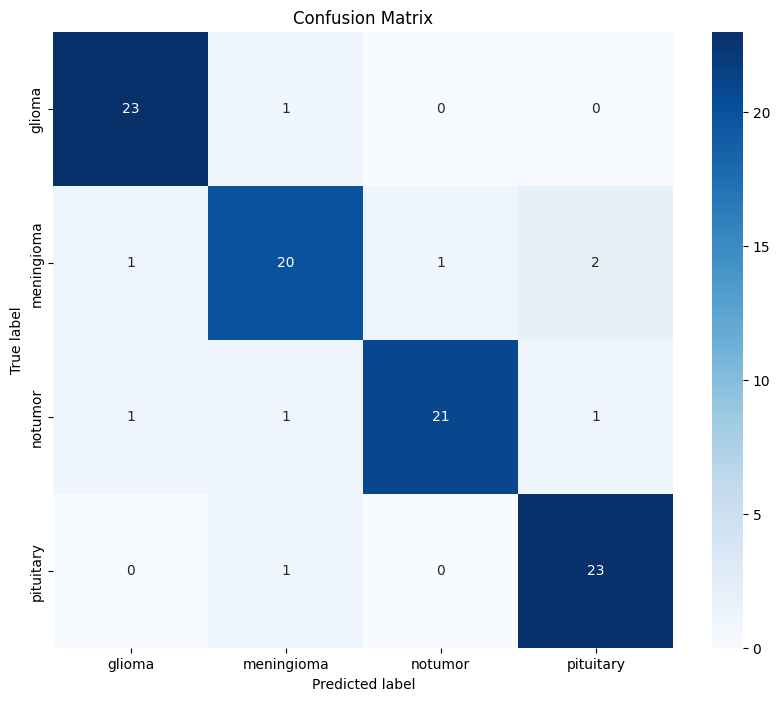

Classification Report
              precision    recall  f1-score   support

      glioma       0.92      0.96      0.94        24
  meningioma       0.87      0.83      0.85        24
     notumor       0.95      0.88      0.91        24
   pituitary       0.88      0.96      0.92        24

    accuracy                           0.91        96
   macro avg       0.91      0.91      0.91        96
weighted avg       0.91      0.91      0.91        96



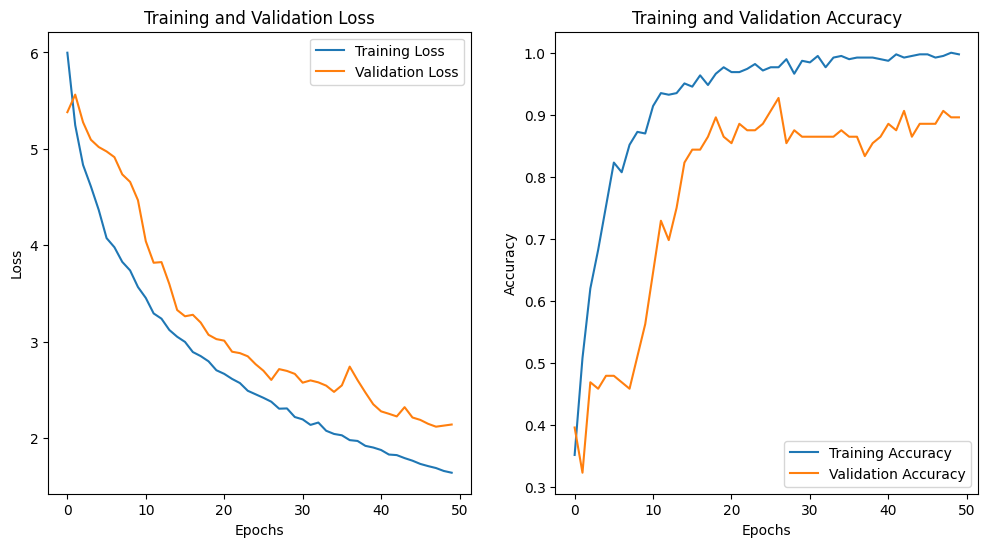

In [61]:
# Load the saved model
loaded_model = load_model('/app/my_model.keras')
print("Model loaded successfully.")

# Evaluate the model
test_loss, test_acc = loaded_model.evaluate(validation_generator)
print(f"Test accuracy: {test_acc}")

# Predict the values from the validation dataset
y_pred = loaded_model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)

# Confusion matrix
confusion_mtx = confusion_matrix(validation_generator.classes, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
target_names = list(validation_generator.class_indices.keys())
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

Image file found: dataset_24/meningioma/Tr-me_0252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Predicted class: meningioma


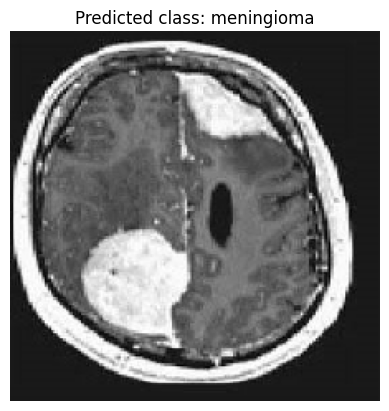

Image file found: dataset_24/pituitary/Te-pi_0081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Predicted class: pituitary


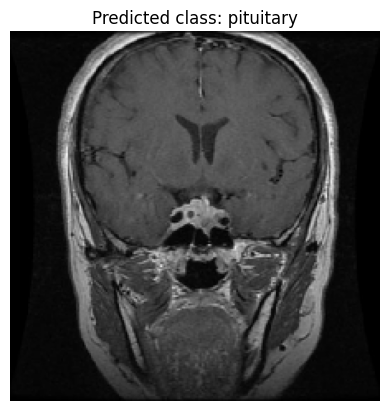

Image file found: dataset_24/glioma/Te-gl_0136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Predicted class: glioma


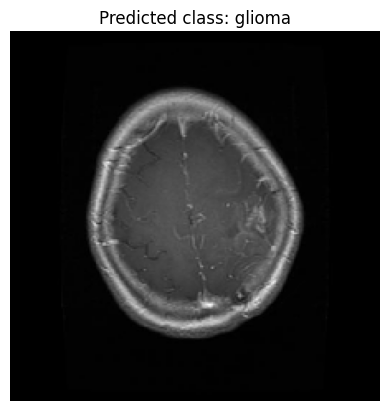

Image file found: dataset_24/notumor/Tr-no_0416.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Predicted class: notumor


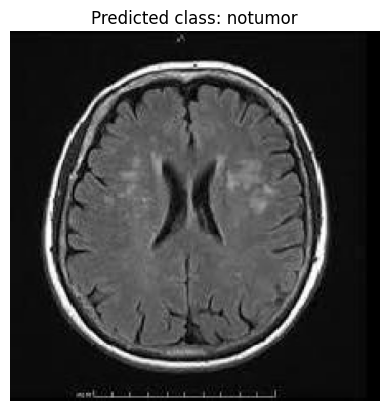

In [85]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the model's input shape
    img_array /= 255.0  # Normalize to [0, 1]
    return img, img_array

# List of image paths
img_paths = [
    "dataset_24/meningioma/Tr-me_0252.jpg",
    "dataset_24/pituitary/Te-pi_0081.jpg",
    "dataset_24/glioma/Te-gl_0136.jpg",
    "dataset_24/notumor/Tr-no_0416.jpg"
]

# Loop through each image path
for img_path in img_paths:
    # Check if the image file exists
    if os.path.exists(img_path):
        print(f"Image file found: {img_path}")
        img, img_array = load_and_preprocess_image(img_path)
        
        # Predict the class of the image
        predictions = loaded_model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)
        class_labels = list(validation_generator.class_indices.keys())
        predicted_label = class_labels[predicted_class[0]]
        print(f"Predicted class: {predicted_label}")
        
        # Display the image with the predicted class label
        plt.figure()
        plt.imshow(img)
        plt.title(f"Predicted class: {predicted_label}")
        plt.axis('off')
        plt.show()
    else:
        print(f"File not found: {img_path}")
